In [1]:
import os
import hashlib
from pathlib import Path
import pandas as pd
import numpy as np
import fastparquet as fp
import scipy.stats
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3, MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout,
                                     concatenate, Input, BatchNormalization,
                                     Activation)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import joblib
from tqdm import tqdm
from IPython.display import display, HTML, clear_output
from ipywidgets import FloatProgress

In [2]:
PROJECT_ROOT = Path('tobacco_grading')

PATHS = {
    'raw': PROJECT_ROOT / 'data/raw',
    'processed': PROJECT_ROOT / 'data/processed/images',
    'metadata': PROJECT_ROOT / 'data/processed/metadata.csv',
    'features': PROJECT_ROOT / 'data/processed/full_features.parquet',
    'processors': PROJECT_ROOT / 'model/processors.pkl',
    'model': PROJECT_ROOT / 'model'
}

for path in PATHS.values():
    if isinstance(path, Path) and path.suffix not in {'.csv', '.parquet', '.pkl'}:
        path.mkdir(parents=True, exist_ok=True)

In [3]:
def show_status(message, status_type='info'):
    status_config = {
        'info': {
            'color': '#004085',
            'bg_color': 'rgba(0, 64, 133, 0.1)',
            'icon': 'ℹ️'
        },
        'success': {
            'color': '#155724',
            'bg_color': 'rgba(40, 167, 69, 0.1)',
            'icon': '✅'
        },
        'warning': {
            'color': '#856404',
            'bg_color': 'rgba(255, 193, 7, 0.1)',
            'icon': '⚠️'
        },
        'error': {
            'color': '#721c24',
            'bg_color': 'rgba(220, 53, 69, 0.1)',
            'icon': '❌'
        }
    }

    config = status_config.get(status_type.lower(), status_config['info'])
    safe_message = HTML(message).data.replace('\n', '<br>')

    html = f"""
    <div style="
        border: 1px solid {config['color']};
        background-color: {config['bg_color']};
        color: {config['color']};
        padding: 12px 18px;
        margin: 10px 0;
        border-radius: 5px;
        font-family: sans-serif;
        font-size: 14px;
        animation: fadeIn 0.5s ease-out;
        line-height: 1.6;
    ">
        <span style="font-weight: bold; margin-right: 8px;">{config['icon']} {status_type.upper()}:</span>
        {safe_message}
    </div>
    <style>
        @keyframes fadeIn {{
            from {{ opacity: 0; transform: translateY(-10px); }}
            to {{ opacity: 1; transform: translateY(0); }}
        }}
    </style>
    """
    display(HTML(html))

In [4]:
def enhanced_process_images():
    clear_output(wait=True)
    show_status("Starting enhanced image processing...", 'info')
    try:
        raw_path = Path(PATHS['raw'])
        if not raw_path.exists():
            show_status(f"Raw data directory not found: {raw_path}", 'error')
            return

        supported_formats = ('.png', '.jpg', '.jpeg', '.webp')
        image_paths = [
            p for p in raw_path.rglob('*')
            if p.suffix.lower() in supported_formats and p.is_file()
        ]

        if not image_paths:
            show_status('No valid images found in raw directory.', 'error')
            return
        show_status(f"Found {len(image_paths)} images to process.", 'info')

        progress = FloatProgress(min=0, max=len(image_paths)+3, description='Initializing:', bar_style='info')
        display(progress)

        processed_paths = []
        original_sizes = []
        failure_count = 0

        progress.description = 'Processing images...'
        processing_params = {
            'target_size': (512, 512),
            'bilateral_filter': {'d': 9, 'sigma_color': 75, 'sigma_space': 75},
            'clahe': {'clip_limit': 3.0, 'tile_grid_size': (8, 8)},
            'quality': 95,
            'denoise_strength': 10,
        }

        for path in image_paths:
            try:
                original_sizes.append(path.stat().st_size)

                img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
                if img is None or img.size == 0:
                    raise ValueError("Invalid or corrupted image file")

                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                elif img.shape[2] == 4:
                    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
                elif img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                else:
                    raise ValueError(f"Unsupported number of channels: {img.shape[2]}")

                img = cv2.fastNlMeansDenoisingColored(
                    img, None,
                    processing_params['denoise_strength'], processing_params['denoise_strength'],
                    7, 21
                )

                img = cv2.resize(
                    img, processing_params['target_size'], interpolation=cv2.INTER_LANCZOS4
                )

                img = cv2.bilateralFilter(
                    img,
                    processing_params['bilateral_filter']['d'],
                    processing_params['bilateral_filter']['sigma_color'],
                    processing_params['bilateral_filter']['sigma_space']
                )

                lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(
                    clipLimit=processing_params['clahe']['clip_limit'],
                    tileGridSize=processing_params['clahe']['tile_grid_size']
                )
                l = clahe.apply(l)
                lab = cv2.merge((l, a, b))
                img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

                kernel = np.array([[-1, -1, -1],
                                   [-1,  9, -1],
                                   [-1, -1, -1]])
                img = cv2.filter2D(img, -1, kernel)

                rel_path = path.relative_to(raw_path)
                dest_path = Path(PATHS['processed']) / rel_path
                dest_path.parent.mkdir(parents=True, exist_ok=True)

                cv2.imwrite(
                    str(dest_path),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
                    [int(cv2.IMWRITE_JPEG_QUALITY), processing_params['quality']]
                )

                processed_paths.append(str(dest_path))

            except Exception as e:
                failure_count += 1
                show_status(f"Skipped {path.name}: {str(e)}", 'warning')
                processed_paths.append(None)

            progress.value += 1

        progress.description = 'Creating metadata...'
        metadata = pd.DataFrame({
            'original_path': [str(p) for p in image_paths],
            'processed_path': processed_paths,
            'label': [p.parent.name for p in image_paths],
            'original_size': original_sizes
        })
        metadata['processing_success'] = metadata['processed_path'].notnull()

        valid_metadata = metadata.dropna(subset=['processed_path']).reset_index(drop=True)
        if valid_metadata.empty:
            show_status('No images were processed successfully. Cannot create metadata.', 'error')
            return

        progress.description = 'Calculating statistics...'
        def get_image_stats(img_path_str):
            try:
                img_path = Path(img_path_str)
                img = cv2.imread(img_path_str)
                if img is None: return None
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                mean_rgb = np.mean(img, axis=(0, 1))
                std_rgb = np.std(img, axis=(0, 1))

                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                mean_hsv = np.mean(hsv, axis=(0, 1))

                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
                hist = hist / hist.sum()
                entropy = -np.sum(hist * np.log2(hist + 1e-7))

                return {
                    'mean_r': mean_rgb[0], 'mean_g': mean_rgb[1], 'mean_b': mean_rgb[2],
                    'std_r': std_rgb[0], 'std_g': std_rgb[1], 'std_b': std_rgb[2],
                    'mean_hue': mean_hsv[0], 'mean_saturation': mean_hsv[1], 'mean_value': mean_hsv[2],
                    'entropy': entropy,
                    'processed_size': img_path.stat().st_size
                }
            except Exception as e:
                return None

        stats_list = [get_image_stats(p) for p in tqdm(valid_metadata['processed_path'], desc="Calculating image statistics")]
        stats_df = pd.DataFrame([s if s is not None else {} for s in stats_list])

        valid_metadata = pd.concat([valid_metadata, stats_df], axis=1)
        progress.value += 1

        progress.description = 'Generating checksums...'
        def calculate_checksum(p_str):
            if pd.isna(p_str): return ''
            try:
                return hashlib.md5(Path(p_str).read_bytes()).hexdigest()
            except FileNotFoundError:
                return ''
            except Exception:
                return ''

        valid_metadata['checksum'] = [calculate_checksum(p) for p in valid_metadata['processed_path']]
        progress.value += 1

        metadata_path = PATHS['metadata']
        valid_metadata.to_csv(metadata_path, index=False)
        show_status(f"Metadata saved to {metadata_path}", 'success')

        clear_output(wait=True)
        success_count = len(valid_metadata)
        total_count = len(image_paths)
        success_rate = success_count / total_count * 100 if total_count > 0 else 0
        total_orig_size = sum(metadata['original_size'])
        total_proc_size = valid_metadata['processed_size'].sum()
        compression_ratio = total_proc_size / total_orig_size if total_orig_size > 0 else 0

        summary = f"""
        Processed {success_count}/{total_count} images successfully ({success_rate:.1f}%)
        - Failures: {failure_count}
        - Input size (Original): {total_orig_size / 1e6:.2f} MB
        - Output size (Processed): {total_proc_size / 1e6:.2f} MB
        - Effective Compression Ratio: {compression_ratio:.2f} (Processed/Original)
        - Average Entropy: {valid_metadata['entropy'].mean():.2f} (Image Complexity)
        - Color analysis completed with {valid_metadata.filter(like='mean_').shape[1]} metrics
        - Checksums generated for processed files.
        """
        show_status(summary, 'success')

        if success_count > 0:
            display(HTML("<h2>Enhanced Processing Report</h2>"))

            label_counts = valid_metadata['label'].value_counts()
            num_labels_to_show = min(3, len(label_counts))
            if num_labels_to_show > 0:
                most_common_labels = label_counts.nlargest(num_labels_to_show).index
                samples = pd.concat([
                    valid_metadata[valid_metadata['label'] == label].sample(1, random_state=42)
                    for label in most_common_labels if not valid_metadata[valid_metadata['label'] == label].empty
                ])

                if not samples.empty:
                    fig, axes = plt.subplots(2, len(samples), figsize=(6 * len(samples), 10))
                    if len(samples) == 1: axes = np.array([[axes[0]],[axes[1]]])

                    for idx, (_, row) in enumerate(samples.iterrows()):
                        try:
                            orig_img = Image.open(row['original_path'])
                            axes[0, idx].imshow(orig_img)
                            axes[0, idx].set_title(f"Original: {row['label']}\n{Path(row['original_path']).name}", fontsize=10)
                        except FileNotFoundError:
                            axes[0, idx].set_title(f"Original: {row['label']}\n(File not found)", fontsize=10)
                        except Exception as img_e:
                            axes[0, idx].set_title(f"Original: {row['label']}\n(Error loading)", fontsize=10)

                        try:
                            proc_img = Image.open(row['processed_path'])
                            axes[1, idx].imshow(proc_img)
                            axes[1, idx].set_title(
                                f"Processed: {row['processed_size']/1e3:.1f} KB | Entropy: {row['entropy']:.2f}\n{Path(row['processed_path']).name}",
                                fontsize=10
                            )
                        except FileNotFoundError:
                            axes[1, idx].set_title(f"Processed:\n(File not found)", fontsize=10)
                        except Exception as img_e:
                            axes[1, idx].set_title(f"Processed:\n(Error loading)", fontsize=10)

                        for ax_row in range(2):
                            axes[ax_row, idx].axis('off')

                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    fig.suptitle("Image Quality Comparison (Sample)", fontsize=16)
                    plt.show()

            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle("Data Distribution Analysis", fontsize=16)

            axes[0, 0].hist(valid_metadata['original_size']/1e3, alpha=0.6, label='Original Size (Success only)', bins=30, color='blue')
            axes[0, 0].hist(valid_metadata['processed_size']/1e3, alpha=0.6, label='Processed Size', bins=30, color='green')
            axes[0, 0].set_xlabel('File Size (KB)')
            axes[0, 0].set_ylabel('Count')
            axes[0, 0].set_title('File Size Distribution')
            axes[0, 0].legend()
            axes[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

            valid_metadata['label'].value_counts().plot(kind='bar', ax=axes[0, 1], color='skyblue')
            axes[0, 1].set_title('Class Distribution (Processed Images)')
            axes[0, 1].set_xlabel('Label')
            axes[0, 1].set_ylabel('Count')
            plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha="right")

            top_classes = valid_metadata['label'].value_counts().nlargest(5).index
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_classes)))
            for i, label in enumerate(top_classes):
                class_data = valid_metadata[valid_metadata['label'] == label]
                axes[1, 0].scatter(
                    class_data['mean_r'], class_data['mean_g'],
                    label=label, alpha=0.7, color=colors[i]
                )
            axes[1, 0].set_title('Mean Red vs Green by Top 5 Classes')
            axes[1, 0].set_xlabel('Mean Red Value')
            axes[1, 0].set_ylabel('Mean Green Value')
            axes[1, 0].legend()

            entropy_by_class = [valid_metadata[valid_metadata['label'] == label]['entropy'].dropna() for label in top_classes]
            axes[1, 1].boxplot(entropy_by_class, labels=top_classes)
            axes[1, 1].set_title('Image Entropy by Top 5 Classes')
            axes[1, 1].set_ylabel('Entropy (Complexity)')
            plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha="right")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    except Exception as e:
        show_status(f'Critical processing failure: {str(e)}', 'error')

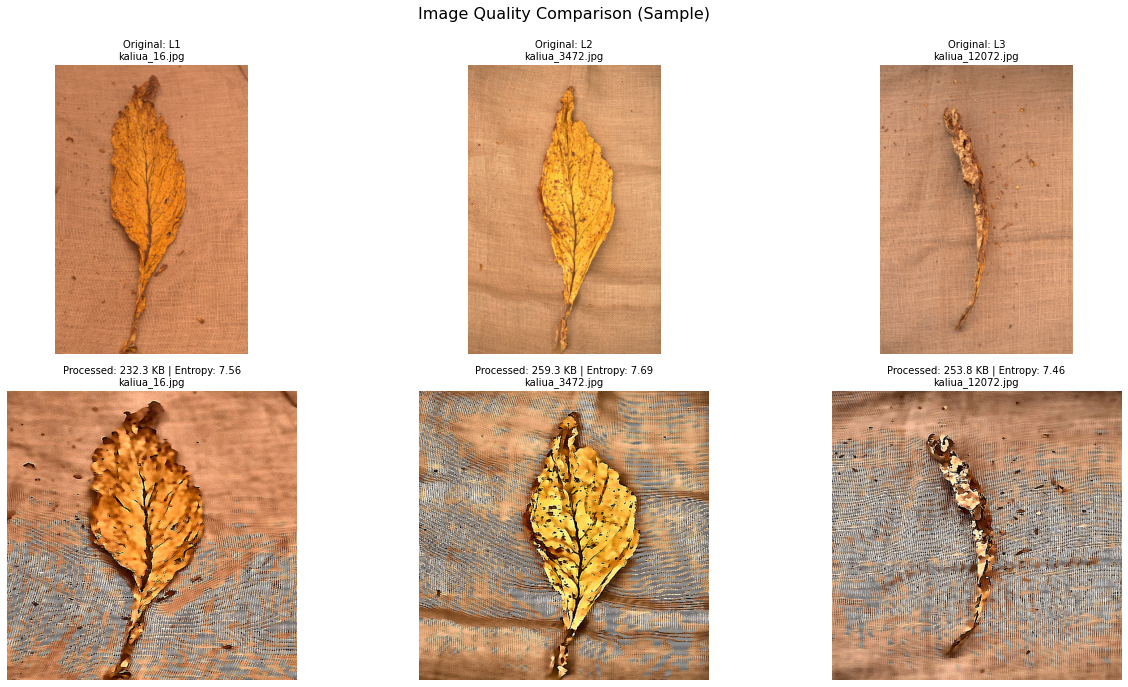

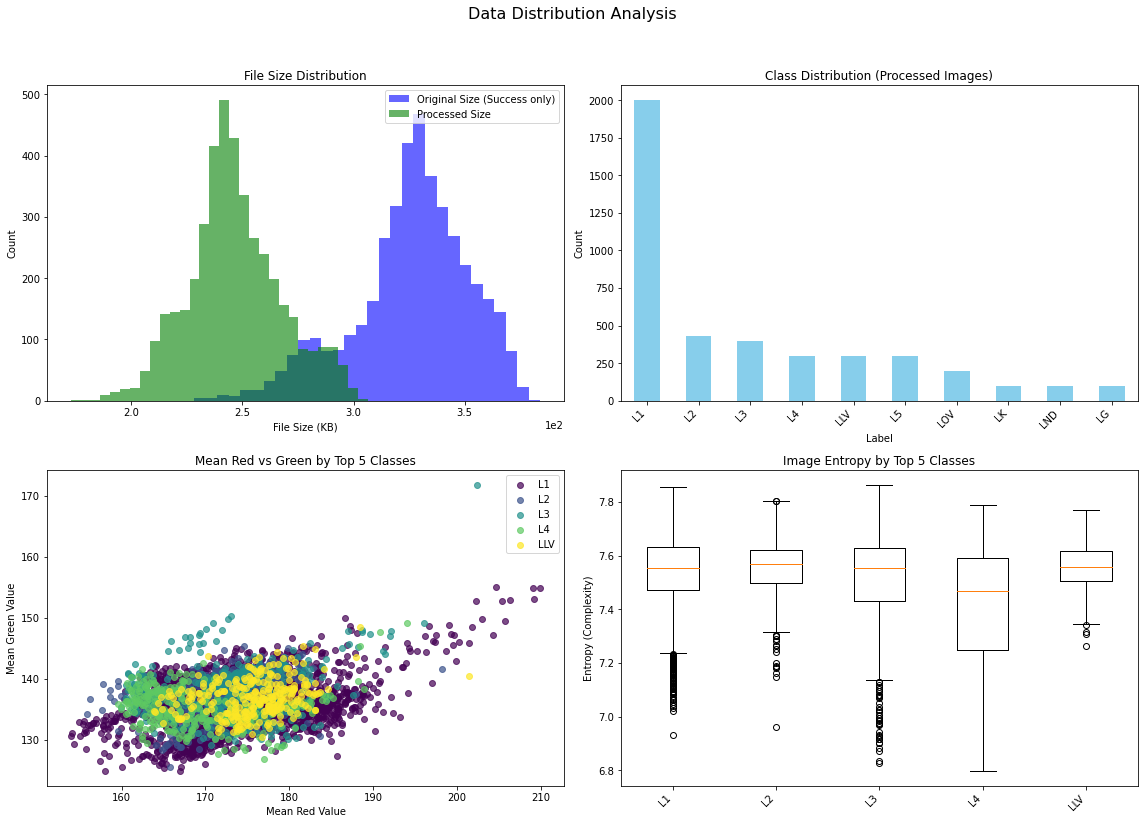

In [5]:
enhanced_process_images()

In [8]:
class EnhancedFeatureExtractor:
    def __init__(self, use_ensemble=True, pca_components=256, target_size=(224, 224), verbose=True):
        self.verbose = verbose
        self.target_size = target_size
        self.input_shape = target_size + (3,)
        self.models = {}
        self.preprocess_funcs = {}
        self.layer_names = {}

        if self.verbose:
            show_status(f"Initializing Feature Extractor (Ensemble: {use_ensemble}, PCA: {pca_components})", 'info')

        try:
            # ResNet50 Base Model
            base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=self.input_shape)
            self.models['resnet'] = base_resnet
            self.preprocess_funcs['resnet'] = resnet_preprocess
            self.layer_names['resnet'] = [
                'conv1_relu', 'conv2_block3_out', 
                'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out'
            ]
            if self.verbose:
                show_status("ResNet50 loaded.", 'success')

            # Conditional Ensemble Models
            self.use_ensemble = use_ensemble
            if use_ensemble:
                # EfficientNetB3
                base_efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=self.input_shape)
                self.models['efficientnet'] = base_efficientnet
                self.preprocess_funcs['efficientnet'] = efficientnet_preprocess
                self.layer_names['efficientnet'] = [
                    'block2a_expand_activation', 'block3a_expand_activation',
                    'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'
                ]
                if self.verbose:
                    show_status("EfficientNetB3 loaded.", 'success')

                # MobileNetV2
                base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)
                self.models['mobilenet'] = base_mobilenet
                self.preprocess_funcs['mobilenet'] = mobilenet_preprocess
                self.layer_names['mobilenet'] = [
                    'block_1_expand_relu', 'block_3_expand_relu',
                    'block_6_expand_relu', 'block_13_expand_relu', 'out_relu'
                ]
                if self.verbose:
                    show_status("MobileNetV2 loaded.", 'success')

        except Exception as e:
            show_status(f"Error loading base CNN models: {e}", 'error')
            raise

        # Feature Model Setup
        self.feature_models = self._create_feature_models()
        
        # Scaler/PCA Configuration
        self.scaler = MinMaxScaler()
        self.is_scaler_fitted = False
        self.use_pca = pca_components is not None and pca_components > 0
        if self.use_pca:
            self.pca = PCA(n_components=pca_components)
            self.is_pca_fitted = False
            if self.verbose:
                show_status(f"PCA enabled with {pca_components} components.", 'info')
        else:
            self.pca = None
            self.is_pca_fitted = False
            if self.verbose:
                show_status("PCA is disabled.", 'info')

    def _create_feature_models(self):
        feature_models = {}
        for name, base_model in self.models.items():
            try:
                if name in self.layer_names:
                    outputs = [base_model.get_layer(layer_name).output 
                              for layer_name in self.layer_names[name]]
                    feature_models[name] = Model(inputs=base_model.input, outputs=outputs, 
                                               name=f"{name}_feature_extractor")
                    if self.verbose:
                        show_status(f"Created feature extractor for {name} with {len(outputs)} layers.", 'info')
                else:
                    output = GlobalAveragePooling2D()(base_model.output)
                    feature_models[name] = Model(inputs=base_model.input, outputs=output,
                                               name=f"{name}_gap_feature_extractor")
                    show_status(f"Using GlobalAveragePooling for {name}.", 'warning')
            except Exception as e:
                show_status(f"Error creating feature model for {name}: {e}", 'warning')
        return feature_models

    def _process_layer_output(self, layer_outputs):
        processed_features = []
        layer_outputs = [layer_outputs] if not isinstance(layer_outputs, list) else layer_outputs
        
        for layer_feat in layer_outputs:
            if len(layer_feat.shape) == 4:
                axis = (1, 2)
                stats = [
                    np.mean(layer_feat, axis=axis),
                    np.max(layer_feat, axis=axis),
                    np.std(layer_feat, axis=axis),
                    np.ptp(layer_feat, axis=axis),
                    np.median(layer_feat, axis=axis)
                ]
                processed_features.append(np.concatenate(stats, axis=1))
            elif len(layer_feat.shape) == 2:
                processed_features.append(layer_feat)
                
        return np.concatenate(processed_features, axis=1) if processed_features else np.array([[]])

    def _load_and_preprocess_image(self, path, model_name):
        try:
            img = cv2.imread(str(path))
            if img is None:
                raise ValueError("Empty image file")

            # Color Conversion
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

            # Preprocessing Pipeline
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB)
            img = cv2.bilateralFilter(img, d=5, sigmaColor=50, sigmaSpace=50)
            img = cv2.resize(img, self.target_size, interpolation=cv2.INTER_LANCZOS4)

            # Model-specific preprocessing
            preprocess_func = self.preprocess_funcs.get(model_name)
            return preprocess_func(np.expand_dims(img.astype(np.float32), axis=0)) if preprocess_func \
                else np.expand_dims(img.astype(np.float32) / 255.0, axis=0)

        except Exception as e:
            if self.verbose:
                show_status(f"Error processing {Path(path).name}: {str(e)}", 'warning')
            return None

    def process_and_save_features(self, image_paths, batch_size=32, fit_processors_on_first_batch=True):
        all_final_features = []
        all_valid_paths = []
        metadata_df = pd.read_csv(PATHS['metadata'])
        image_paths = [Path(p) for p in image_paths]
        total_images = len(image_paths)

        if self.verbose:
            show_status(f"Starting feature extraction for {total_images} images", 'info')

        with tqdm(total=total_images, desc="Feature Extraction", disable=not self.verbose) as pbar:
            fit_flag = fit_processors_on_first_batch
            for i in range(0, total_images, batch_size):
                batch_paths = image_paths[i:i+batch_size]
                final_features, valid_paths = self.process_batch(batch_paths, fit_flag)
                fit_flag = False
                
                if final_features.size > 0:
                    all_final_features.append(final_features)
                    all_valid_paths.extend([str(p) for p in valid_paths])
                
                pbar.update(len(batch_paths))

        if not all_valid_paths:
            show_status("No features extracted successfully.", 'error')
            return None

        # Feature Matrix Assembly
        final_feature_matrix = np.vstack(all_final_features)
        if self.verbose:
            show_status(f"Extracted features shape: {final_feature_matrix.shape}", 'success')

        # Merge with Metadata
        features_df = pd.DataFrame(final_feature_matrix, 
                                 columns=[f"feat_{i}" for i in range(final_feature_matrix.shape[1])])
        features_df['processed_path'] = all_valid_paths
        final_df = pd.merge(metadata_df[metadata_df['processed_path'].isin(all_valid_paths)],
                           features_df, on='processed_path', how='inner')

        # Save Results
        try:
            fp.write(str(PATHS['features']), final_df, compression='SNAPPY')
            if self.verbose:
                show_status(f"Features saved to {PATHS['features']}", 'success')
            self.save_processors(PATHS['processors'])
            return PATHS['features']
        except Exception as e:
            show_status(f"Error saving features: {e}", 'error')
            return None

    def process_batch(self, image_paths, fit_processors=False):
        batch_features = {name: [] for name in self.models}
        valid_paths = []
        processed_images = {name: [] for name in self.models}

        for path in image_paths:
            temp_images = {}
            for model_name in self.models:
                img = self._load_and_preprocess_image(path, model_name)
                if img is None: break
                temp_images[model_name] = img[0]
            else:
                valid_paths.append(path)
                for name, img in temp_images.items():
                    processed_images[name].append(img)

        if not valid_paths:
            return np.array([]), []

        # Feature Extraction
        for model_name, feature_model in self.feature_models.items():
            if not self.use_ensemble and model_name != 'resnet':
                continue
                
            imgs = np.array(processed_images.get(model_name, []))
            if imgs.size == 0:
                continue
                
            layer_outputs = feature_model.predict(imgs, verbose=0)
            batch_features[model_name] = self._process_layer_output(layer_outputs)

        # Feature Combination
        combined_features = np.concatenate(list(batch_features.values()), axis=1) \
            if self.use_ensemble else batch_features.get('resnet', np.array([]))

        # Feature Processing
        if fit_processors:
            if combined_features.shape[0] > 1:
                self.scaler.fit(combined_features)
                self.is_scaler_fitted = True
                if self.verbose:
                    show_status("Scaler successfully fitted.", 'info')
            elif self.verbose:
                show_status("Insufficient samples for scaler fitting.", 'warning')

        scaled_features = self.scaler.transform(combined_features) if self.is_scaler_fitted else combined_features
        
        # PCA Handling
        if self.use_pca:
            if fit_processors and scaled_features.shape[0] >= self.pca.n_components:
                self.pca.fit(scaled_features)
                self.is_pca_fitted = True
                if self.verbose:
                    explained_var = sum(self.pca.explained_variance_ratio_)
                    show_status(f"PCA fitted (Explained Variance: {explained_var:.2%})", 'success')
            return self.pca.transform(scaled_features) if self.is_pca_fitted else scaled_features, valid_paths
        
        return scaled_features, valid_paths

    def save_processors(self, path):
        if not self.is_scaler_fitted and not self.is_pca_fitted:
            if self.verbose:
                show_status("No processors to save.", 'warning')
            return

        processors = {
            'scaler': self.scaler if self.is_scaler_fitted else None,
            'pca': self.pca if self.use_pca and self.is_pca_fitted else None,
            'config': {
                'use_pca': self.use_pca,
                'is_scaler_fitted': self.is_scaler_fitted,
                'is_pca_fitted': self.is_pca_fitted
            }
        }
        
        try:
            joblib.dump(processors, path)
            if self.verbose:
                show_status(f"Processors saved to {path}", 'success')
        except Exception as e:
            show_status(f"Error saving processors: {e}", 'error')

    def load_processors(self, path):
        try:
            processors = joblib.load(path)
            self.scaler = processors.get('scaler')
            self.pca = processors.get('pca')
            config = processors.get('config', {})
            
            self.use_pca = config.get('use_pca', False)
            self.is_scaler_fitted = config.get('is_scaler_fitted', False)
            self.is_pca_fitted = config.get('is_pca_fitted', False)

            status = []
            if self.is_scaler_fitted:
                status.append("Scaler loaded")
            if self.pca and self.is_pca_fitted:
                status.append(f"PCA loaded ({self.pca.n_components_} components)")
                
            if status:
                show_status("Loaded processors: " + "; ".join(status), 'success')
            elif self.verbose:
                show_status("No valid processors loaded.", 'warning')

        except Exception as e:
            show_status(f"Error loading processors: {e}", 'error')

In [9]:
feature_extractor = EnhancedFeatureExtractor(
    use_ensemble=True,
    pca_components=200,
    target_size=(224, 224)
)

In [10]:
metadata = pd.read_csv(PATHS['metadata'])
valid_image_paths = metadata['processed_path'].dropna().tolist()

In [11]:
feature_extractor.process_and_save_features(
    valid_image_paths,
    batch_size=16,
    fit_processors_on_first_batch=True)  # Crucial for PCA/scaler

Feature Extraction:   0%|          | 0/4226 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 4226/4226 [52:17<00:00,  1.35it/s]


WindowsPath('tobacco_grading/data/processed/full_features.parquet')

In [12]:
def train_custom_cnn(X_train, y_train, X_val, y_val, classes, input_shape=(224, 224, 3)):
    num_classes = len(classes)
    show_status(f"Setting up custom CNN for {num_classes} classes.", "info")

    if len(X_train.shape) != 4 or X_train.shape[1:] != input_shape:
        msg = f"Input X_train shape {X_train.shape} is not suitable for CNN input {input_shape}."
        show_status(msg, "error")
        raise ValueError(msg)
    if len(X_val.shape) != 4 or X_val.shape[1:] != input_shape:
        msg = f"Input X_val shape {X_val.shape} is not suitable for CNN input {input_shape}."
        show_status(msg, "error")
        raise ValueError(msg)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(512, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        Dense(256, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ], name="Custom_ResNet_FineTuned")

    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]

    class_map = {label: i for i, label in enumerate(classes)}
    y_train_mapped = np.array([class_map[label] for label in y_train])
    y_val_mapped = np.array([class_map[label] for label in y_val])

    y_train_cat = to_categorical(y_train_mapped, num_classes=num_classes)
    y_val_cat = to_categorical(y_val_mapped, num_classes=num_classes)

    show_status("Starting CNN training...", "info")
    history = model.fit(
        X_train, y_train_cat,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )
    show_status("CNN training finished.", "success")

    return model, history

def create_knn_classifier(X_train, y_train):
    show_status("Creating and training KNN classifier...", 'info')

    knn = KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )

    try:
        knn.fit(X_train, y_train)
        show_status("KNN training complete.", 'success')
        return knn
    except Exception as e:
        show_status(f"Error during KNN training: {e}", 'error')
        raise

def perform_feature_augmentation(X, y, strategy='smote', random_state=42):
    show_status(f"Applying data augmentation/balancing strategy: {strategy}", 'info')
    original_counts = pd.Series(y).value_counts()
    show_status(f"Original class distribution:\n{original_counts.to_string()}", 'info')

    try:
        if strategy == 'smote':
            min_samples = original_counts.min()
            n_neighbors = min(5, min_samples - 1)

            if n_neighbors < 1:
                show_status(f"Skipping SMOTE: Minimum class sample ({min_samples}) is too small for k_neighbors.", 'warning')
                return X, y

            smote = SMOTE(random_state=random_state, k_neighbors=n_neighbors)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            final_counts = pd.Series(y_resampled).value_counts()
            show_status(f"Resampled class distribution:\n{final_counts.to_string()}", 'success')
            return X_resampled, y_resampled

        else:
            show_status(f"Unknown augmentation strategy: {strategy}. Returning original data.", 'warning')
            return X, y

    except Exception as e:
        show_status(f"Error during data augmentation ({strategy}): {e}", 'error')
        return X, y

def create_hybrid_model(cnn_model_path, X_train_images, y_train, X_val_images, y_val, classes):
    show_status(f"Creating hybrid model using CNN from: {cnn_model_path}", 'info')

    try:
        cnn_model = tf.keras.models.load_model(cnn_model_path)
        show_status("Loaded pre-trained CNN model.", 'success')
    except Exception as e:
        show_status(f"Error loading CNN model: {e}", 'error')
        raise

    feature_layer_index = -2
    try:
        feature_extractor = Model(
            inputs=cnn_model.input,
            outputs=cnn_model.layers[feature_layer_index].output,
            name="CNN_Feature_Extractor"
        )
        show_status(f"Using layer '{cnn_model.layers[feature_layer_index].name}' for feature extraction.", 'info')
    except Exception as e:
        show_status(f"Could not automatically determine feature layer at index {feature_layer_index}. Error: {e}", 'error')
        raise ValueError("Failed to create feature extractor from CNN.")

    show_status("Extracting deep features using the CNN...", 'info')
    X_train_deep = feature_extractor.predict(X_train_images, batch_size=32, verbose=1)
    X_val_deep = feature_extractor.predict(X_val_images, batch_size=32, verbose=1)

    show_status("Scaling deep features...", 'info')
    scaler = StandardScaler()
    X_train_deep_scaled = scaler.fit_transform(X_train_deep)
    X_val_deep_scaled = scaler.transform(X_val_deep)

    show_status("Training KNN classifier on deep features...", 'info')
    knn = KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )
    knn.fit(X_train_deep_scaled, y_train)
    show_status("KNN trained successfully on deep features.", 'success')

    val_accuracy = knn.score(X_val_deep_scaled, y_val)
    show_status(f"Hybrid KNN validation accuracy: {val_accuracy:.4f}", 'info')

    return {
        'feature_extractor': feature_extractor,
        'scaler': scaler,
        'knn': knn
    }

def predict_with_hybrid_model(hybrid_components, X_images):
    feature_extractor = hybrid_components['feature_extractor']
    scaler = hybrid_components['scaler']
    knn = hybrid_components['knn']

    X_deep = feature_extractor.predict(X_images, batch_size=32, verbose=0)
    X_deep_scaled = scaler.transform(X_deep)
    predictions = knn.predict(X_deep_scaled)
    probabilities = knn.predict_proba(X_deep_scaled)

    return predictions, probabilities

In [13]:
def enhanced_train_and_evaluate_knn_with_pca(n_components_pca=100):
    clear_output(wait=True)
    show_status("Starting KNN Training and Evaluation Process with PCA...", 'info')
    progress = FloatProgress(min=0, max=8, description='Initializing...', bar_style='info')
    display(progress)

    try:
        progress.value += 1
        progress.description = "Loading Features..."
        feature_path = PATHS['features']

        if not feature_path.exists():
            raise FileNotFoundError(f"Feature file not found at {feature_path}")
        df = pd.read_parquet(feature_path)

        # Data validation
        if df.empty or 'label' not in df.columns or df.isnull().sum().sum() > 0:
            raise ValueError("Invalid feature file structure")

        X = df.filter(like='feat_').values
        y = df['label'].values
        classes, class_counts = np.unique(y, return_counts=True)

        # Class validation
        min_samples = 20
        if np.any(class_counts < min_samples):
            raise ValueError(f"Classes need at least {min_samples} samples")

        progress.value += 1
        progress.description = f"Applying PCA ({n_components_pca})..."
        pca = PCA(n_components=n_components_pca, random_state=42)
        X_pca = pca.fit_transform(X)

        progress.value += 1
        progress.description = "Balancing Data..."
        X_balanced, y_balanced = perform_feature_augmentation(X_pca, y)
        if X_balanced.shape[0] <= X_pca.shape[0]:
            X_balanced, y_balanced = X_pca.copy(), y.copy()
            show_status("SMOTE failed, using original data", 'warning')

        progress.value += 1
        progress.description = "Splitting Data..."
        test_size = 0.2 if len(y_balanced) > 1000 else 0.15
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced,
            test_size=test_size,
            stratify=y_balanced,
            random_state=42
        )

        progress.value += 1
        progress.description = "Tuning Model..."
        param_grid = {
            'n_neighbors': [3,5,7] if len(y_train) < 500 else [3,5,7,9,11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'cosine']
        }
        
        grid_search = GridSearchCV(
            KNeighborsClassifier(),
            param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True),
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_knn = grid_search.best_estimator_

        progress.value += 1
        progress.description = "Evaluating..."
        y_pred = best_knn.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)

        progress.value += 1
        progress.description = "Saving Model..."
        model_path = PATHS['model'] / 'best_knn_model_pca.pkl'
        joblib.dump({
            'model': best_knn,
            'metadata': {
                'pca_components': n_components_pca,
                'test_accuracy': test_accuracy,
                'class_distribution': dict(zip(classes, class_counts))
            }
        }, model_path)

        progress.value += 1
        progress.description = "Generating Report..."
        
        def enhanced_evaluation_report(y_test, y_pred, classes, test_accuracy, grid_search):
            from IPython.display import display, HTML
            import seaborn as sns

            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
            report_df = pd.DataFrame(report).transpose().reset_index()
            report_df.columns = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support']

            # Create compatible styled table
            styled_html = report_df.to_html(
                index=False,
                formatters={
                    'Precision': '{:.2%}'.format,
                    'Recall': '{:.2%}'.format,
                    'F1-Score': '{:.2%}'.format
                },
                classes='table table-striped table-hover'
            )

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred, labels=classes)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=classes, yticklabels=classes)
            plt.title('Confusion Matrix', pad=20)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            cm_plot = plt.gcf()

            # HTML Report
            html = f"""
            <div style="
                border: 1px solid #e0e0e0;
                border-radius: 8px;
                padding: 20px;
                margin: 20px 0;
                background: white;
            ">
                <h2 style="color: #2c3e50; margin-top: 0">Classification Report</h2>

                <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 30px">
                    <div>
                        <h3 style="color: #3498db">Key Metrics</h3>
                        <ul style="list-style: none; padding-left: 0">
                            <li>🏆 Test Accuracy: <strong>{test_accuracy:.2%}</strong></li>
                            <li>📊 Best Parameters: {grid_search.best_params_}</li>
                            <li>📈 Best F1-Score: {grid_search.best_score_:.2%}</li>
                        </ul>
                    </div>

                    <div>
                        <h3 style="color: #3498db">Data Reliability</h3>
                        <div style="background: #fff3cd; padding: 10px; border-radius: 4px">
                            ⚠️ Note: Results based on {len(y_test)} test samples
                        </div>
                    </div>
                </div>

                <h3 style="color: #3498db; margin-top: 20px">Detailed Metrics</h3>
                {styled_html}

                <h3 style="color: #3498db; margin-top: 20px">Confusion Matrix</h3>
            </div>
            """

            display(HTML(html))
            plt.show()
            plt.close()
        
        # Generate the enhanced report
        enhanced_evaluation_report(y_test, y_pred, classes, test_accuracy, grid_search)

        show_status(
            f"✅ Training complete!\n"
            f"🔍 PCA Components: {n_components_pca}\n"
            f"🏆 Final Accuracy: {test_accuracy:.2%}",
            'success'
        )

        return best_knn, None, grid_search

    except Exception as e:
        show_status(f"❌ Training failed: {str(e)}", 'error')
        return None, None, None

FloatProgress(value=0.0, bar_style='info', description='Initializing...', max=8.0)

Class,Precision,Recall,F1-Score,Support
L1,91.67%,30.25%,45.49%,400.000000
L2,87.13%,96.74%,91.69%,399.000000
L3,91.57%,95.00%,93.25%,400.000000
L4,93.95%,97.00%,95.45%,400.000000
L5,89.68%,97.75%,93.54%,400.000000
LG,92.72%,98.75%,95.64%,400.000000
LK,95.17%,98.50%,96.81%,400.000000
LLV,84.43%,99.00%,91.14%,400.000000
LND,91.65%,99.00%,95.18%,399.000000
LOV,93.08%,97.50%,95.24%,400.000000


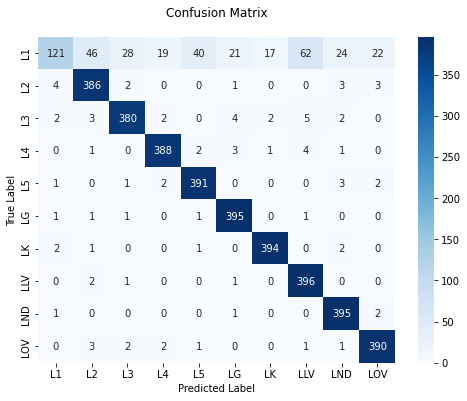

In [14]:
# 1. Run training and capture results
best_knn, _, grid_search = enhanced_train_and_evaluate_knn_with_pca(n_components_pca=200)

# 2. Now save the model (this should come AFTER the training call)
if best_knn is not None:
    # Initialize feature extractor if needed
    if 'feature_extractor' not in globals():
        feature_extractor = EnhancedFeatureExtractor(verbose=False)
    
    # Verify components exist
    if not hasattr(feature_extractor, 'pca') or not hasattr(feature_extractor, 'scaler'):
        show_status("Missing preprocessing components - run feature extraction first", 'error')
    else:
        joblib.dump({
            'model': best_knn,
            'pca': feature_extractor.pca,
            'scaler': feature_extractor.scaler,
            'classes': best_knn.classes_
        }, 'tobacco_model_v1.joblib')
        show_status("Model successfully saved!", 'success')
else:
    show_status("Cannot save model - training failed", 'error')